In [ ]:
!gdown https://drive.google.com/uc?id=1lRw3X7oFNq_WyzBO6uyUJijyTuYm23VS
!tar -xzf sen1floods11_v1.1.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1lRw3X7oFNq_WyzBO6uyUJijyTuYm23VS
From (redirected): https://drive.google.com/uc?id=1lRw3X7oFNq_WyzBO6uyUJijyTuYm23VS&confirm=t&uuid=e231bda3-e825-4759-bc27-8cbe5230a9b7
To: /content/sen1floods11_v1.1.tar.gz
100% 1.77G/1.77G [00:14<00:00, 122MB/s]


In [ ]:
from torch.utils.data import Dataset
import os
import pandas as pd
import geopandas
import tqdm
from google.cloud.storage import Client
import torch
import rasterio
import concurrent
import numpy as np
import torchvision
from matplotlib import pyplot as plt

In [ ]:
class Sen1Floods11(Dataset):
    def __init__(
        self,
        split: str,
        root_path: str,
    ):
        """Initialize the Sen1Floods11 dataset.
        Link: https://github.com/cloudtostreet/Sen1Floods11

        Args:
            split (str): split of the dataset (train, val, test).
            root_path (str): root path of the dataset.
        """

        self.root_path = root_path
        self.split = split

        self.distribution = [0.905, 0.095]

        self.split_mapping = {"train": "train", "val": "valid", "test": "test"}

        split_file = os.path.join(
            self.root_path,
            f"splits/flood_{self.split_mapping[split]}_data.txt",
        )
        metadata_file = os.path.join(
            self.root_path, "Sen1Floods11_Metadata.geojson"
        )
        data_root = os.path.join(
            self.root_path, "data/"
        )

        self.metadata = geopandas.read_file(metadata_file)

        with open(split_file) as f:
            file_list = f.readlines()

        file_list = [f.strip() for f in file_list]

        self.s1_image_list = [
            os.path.join(data_root, "S1GRDHand", f+"_S1Hand.tif") for f in file_list
        ]
        self.s2_image_list = [
            os.path.join(data_root, "S2L1CHand", f+"_S2Hand.tif")
            for f in file_list
        ]
        self.target_list = [
            os.path.join(data_root, "LabelHand", f+"_LabelHand.tif") for f in file_list
        ]

    def __len__(self):
        return len(self.s1_image_list)

    def _get_date(self, index):
        file_name = self.s2_image_list[index]
        location = os.path.basename(file_name).split("_")[0]
        if self.metadata[self.metadata["location"] == location].shape[0] != 1:
            date = pd.to_datetime("13-10-1998", dayfirst=True)
        else:
            date = pd.to_datetime(
                self.metadata[self.metadata["location"] == location]["s2_date"].item()
            )
        date_np = np.zeros((1, 3))
        date_np[0, 0] = date.year
        date_np[0, 1] = date.dayofyear - 1  # base 0
        date_np[0, 2] = date.hour
        return date_np

    def __getitem__(self, index):
        with rasterio.open(self.s2_image_list[index]) as src:
            s2_image = src.read()

        with rasterio.open(self.s1_image_list[index]) as src:
            s1_image = src.read()
            # Convert the missing values (clouds etc.)
            s1_image = np.nan_to_num(s1_image)

        with rasterio.open(self.target_list[index]) as src:
            target = src.read(1)

        timestamp = self._get_date(index)

        s2_image = torch.from_numpy(s2_image).float()
        s1_image = torch.from_numpy(s1_image).float()
        target = torch.from_numpy(target).long()

        mean_s2 = [1626.91600224,1396.03470631,1364.06118417,1218.22847919,1466.07290663,2386.90297537,2845.61256277,2622.95796892,3077.48221481,486.87436782,63.77861008,2030.64763024,1179.16607221]
        std_s2 = [700.17133846,739.09452682,735.2482388,864.936695,776.8803358,921.36834309,1084.37346097,1022.63418007,1196.44255318,336.61105431,143.99923282,980.87061347,764.60836557]
        mean_s1 = [-10.184408, -16.895273]
        std_s1 = [4.255339 , 5.290568]

        s2_image = torchvision.transforms.Normalize(mean_s2, std_s2)(s2_image)
        s1_image = torchvision.transforms.Normalize(mean_s1, std_s1)(s1_image)
        print(s2_image.shape)

        ## resize img to 120
        # s2_image = torchvision.transforms.Resize((120,120))(s2_image)
        # s1_image = torchvision.transforms.Resize((120,120))(s1_image)
        # target = torchvision.transforms.Resize((120,120))(target)
        output = {
            "image": {
                "optical": s2_image,
                "sar": s1_image,
            },
            "target": target,
            "metadata": {
                "timestamp": timestamp,
            },
        }

        return output


In [ ]:
dataset = Sen1Floods11(
    "train",
    "./sen1floods11_v1.1",
  )

In [ ]:
img_num = 50
image_s2 = dataset[img_num]['image']['optical']
image_s2.shape

torch.Size([13, 512, 512])


torch.Size([13, 512, 512])

Text(0.5, 1.0, 'Target Label')

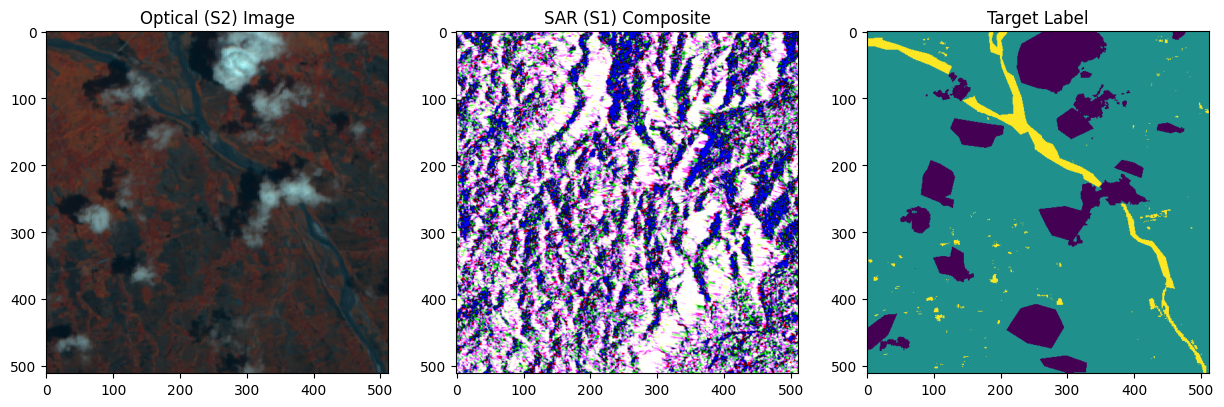

In [ ]:
img_num = 50
image_s2 = dataset[img_num]['image']['optical'].permute(1,2,0)[:,:,[8,4,3]]
image_s2 = image_s2 - image_s2.min()
image_s2 = image_s2 / image_s2.max()

image_s1_raw = dataset[55]['image']['sar']

# Create a 3rd band that is VV/VH
vv_band = image_s1_raw[0, :, :]
vh_band = image_s1_raw[1, :, :]
vv_vh_ratio = vv_band / (vh_band + 1e-6) # Add epsilon to avoid division by zero

image_s1_composite = torch.stack([vv_band, vh_band, vv_vh_ratio], dim=0)

# Normalize image_s1_composite for display
image_s1_display = image_s1_composite - image_s1_composite.min()
image_s1_display = image_s1_display / image_s1_display.max()

# Permute dimensions for matplotlib (Height, Width, Channels)
image_s1_display = image_s1_composite.permute(1, 2, 0)

target = dataset[img_num]['target']

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image_s2)
ax[1].imshow(image_s1_display)
ax[2].imshow(target)

ax[0].set_title('Optical (S2) Image')
ax[1].set_title('SAR (S1) Composite')
ax[2].set_title('Target Label')

In [ ]:
from torch.utils.data import DataLoader

batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, width_multiplier=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        width_pyramid = (np.array([64, 128, 256, 512, 1024]) * width_multiplier).astype(np.int16)

        self.inc = DoubleConv(n_channels, width_pyramid[0])
        self.down1 = Down(width_pyramid[0], width_pyramid[1])
        self.down2 = Down(width_pyramid[1], width_pyramid[2])
        self.down3 = Down(width_pyramid[2], width_pyramid[3])
        self.down4 = Down(width_pyramid[3], width_pyramid[3])
        self.up1 = Up(width_pyramid[4], width_pyramid[2], bilinear)
        self.up2 = Up(width_pyramid[3], width_pyramid[1], bilinear)
        self.up3 = Up(width_pyramid[2], width_pyramid[0], bilinear)
        self.up4 = Up(width_pyramid[1], width_pyramid[0], bilinear)
        self.outc = OutConv(width_pyramid[0], n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Here's an example of how to instantiate the U-Net and pass some dummy data through it to verify its shape:

In [ ]:
n_channels = 13  # Number of input channels for optical (S2) images
n_classes = 2    # Number of output classes (e.g., flood/no-flood)

unet_model = UNet(n_channels=n_channels, n_classes=n_classes, width_multiplier=0.25)

total_params = 0
for parameter in unet_model.parameters():
  total_params += parameter.numel()
print(f"Total number of parameters: {total_params}")

dummy_input = torch.randn(1, n_channels, 256, 256)
output = unet_model(dummy_input)
print(f"model output shape: {output.shape}")

Total number of parameters: 841234
model output shape: torch.Size([1, 2, 256, 256])


# Training loop

In [ ]:
import torch.optim as optim
import tqdm

def train_model_on_sen1floods11(model, n_epochs=1, balance_classes=False):

  class_distribution = dataset.distribution
  class_weights = torch.tensor([1.0, 1.0])
  if balance_classes:
    class_weights = torch.tensor([1.0 / (dist + 1e-6) for dist in class_distribution], dtype=torch.float32)

  print(f"Class Distribution: {class_distribution}")
  print(f"Calculated Class Weights: {class_weights}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), ignore_index=-1)

  model.to(device)

  print(f"Starting training on {device}...")
  model.train()
  for epoch in range(n_epochs):
      running_loss = 0.0
      # Wrap dataloader with tqdm for a progress bar
      with tqdm.tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}") as pbar:
          for i, data in pbar:
              optical_images = data["image"]["optical"].to(device)
              targets = data["target"].to(device)

              optimizer.zero_grad()

              outputs = unet_model(optical_images)

              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()

              running_loss += loss.item()

              # Update tqdm postfix with current loss
              if i % 10 == 9: # Update every 10 batches
                  avg_loss = running_loss / 10
                  pbar.set_postfix({'loss': f'{avg_loss:.4f}'})
                  running_loss = 0.0


In [ ]:
train_model_on_sen1floods11(unet_model, n_epochs=1)

Class Distribution: [0.905, 0.095]
Calculated Class Weights: tensor([1., 1.])
Starting training on cuda...


Epoch 1: 100%|██████████| 63/63 [00:19<00:00,  3.31it/s, loss=0.2362]


In [ ]:
# @title
def evaluate_model(model, dataloader, device):
    """Evaluates the model on the given dataloader and returns average loss and IoU."""
    model.eval()
    total_iou = 0.0
    num_batches = 0
    epsilon = 1e-6 # Small value to avoid division by zero

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            optical_images = data["image"]["optical"].to(device)
            targets = data["target"].to(device)

            outputs = model(optical_images)

            # Calculate IoU
            predictions = torch.argmax(outputs, dim=1)

            valid_pixels_mask = (targets != -1)
            targets_flat_valid = targets[valid_pixels_mask]
            predictions_flat_valid = predictions[valid_pixels_mask]

            if targets_flat_valid.numel() > 0: # Ensure there are valid pixels to calculate IoU
                intersection = ((predictions_flat_valid == 1) & (targets_flat_valid == 1)).sum().item()
                union = ((predictions_flat_valid == 1) | (targets_flat_valid == 1)).sum().item()

                if union == 0:
                    # If there's no flood in ground truth or prediction, IoU is 1 if both are empty, 0 otherwise
                    iou_batch = 1.0 if intersection == 0 else 0.0
                else:
                    iou_batch = intersection / (union + epsilon)
                total_iou += iou_batch
                num_batches += 1
    avg_iou = total_iou / num_batches if num_batches > 0 else 0.0

    return avg_iou


def plot_prediction_examples(model, dataset, device, num_examples=3):
    """Plots a few prediction examples from the dataset."""
    model.eval() # Set the model to evaluation mode

    fig, axes = plt.subplots(num_examples, 4, figsize=(18, 5 * num_examples))
    fig.suptitle('Model Predictions vs. Ground Truth', fontsize=16)

    random_indices = torch.randint(0, len(dataset), (num_examples,)).tolist()

    for i, idx in enumerate(random_indices):
        data = dataset[idx]

        # Prepare S2 image for display
        image_s2 = data['image']['optical'].permute(1,2,0)[:,:,[8,4,3]] # RGB channels
        image_s2 = image_s2 - image_s2.min()
        image_s2 = image_s2 / image_s2.max()

        # Prepare S1 composite for display (VV, VH, VV/VH ratio)
        image_s1_raw = data['image']['sar']
        vv_band = image_s1_raw[0, :, :]
        vh_band = image_s1_raw[1, :, :]
        vv_vh_ratio = vv_band / (vh_band + 1e-6)
        image_s1_composite = torch.stack([vv_band, vh_band, vv_vh_ratio], dim=0)

        # image_s1_display = image_s1_composite - image_s1_composite.min()
        # image_s1_display = image_s1_display / image_s1_display.max()
        image_s1_display = image_s1_composite.permute(1, 2, 0)

        target = data['target']

        # Model inference
        optical_input = data['image']['optical'].unsqueeze(0).to(device) # Add batch dimension
        with torch.no_grad():
            outputs = model(optical_input)
        prediction = torch.argmax(outputs, dim=1).squeeze(0) # Remove batch dimension

        # Plotting
        axes[i, 0].imshow(image_s2.cpu().numpy())
        axes[i, 0].set_title(f'Sample {idx} S2 Optical')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(image_s1_display.cpu().numpy())
        axes[i, 1].set_title(f'Sample {idx} S1 SAR')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(target.cpu().numpy(), cmap='gray') # Assuming binary target
        axes[i, 2].set_title(f'Sample {idx} Ground Truth')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(prediction.cpu().numpy(), cmap='gray') # Assuming binary prediction
        axes[i, 3].set_title(f'Sample {idx} Prediction')
        axes[i, 3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Validation

Validation IoU (Flood Class): 0.6220


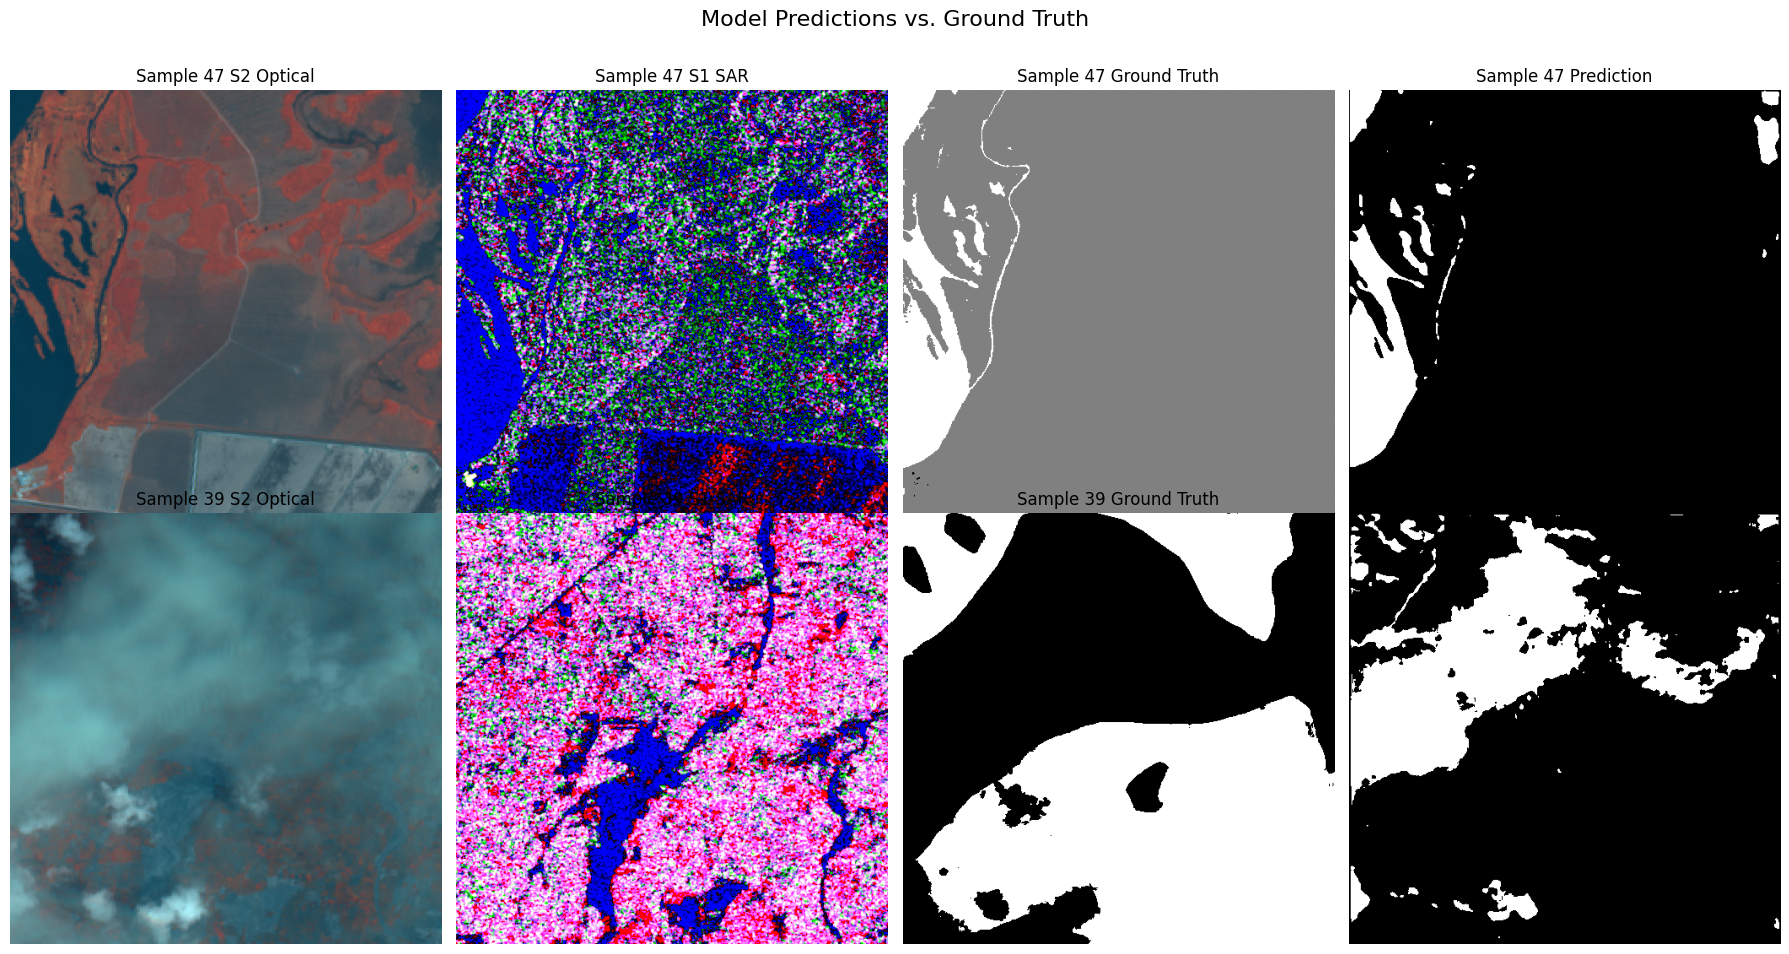

In [ ]:
val_dataset = Sen1Floods11(
    "val",
    "./sen1floods11_v1.1",
  )
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle validation data

val_iou = evaluate_model(unet_model, val_dataloader, "cuda")
print(f"Validation IoU (Flood Class): {val_iou:.4f}")

plot_prediction_examples(unet_model, val_dataset, "cuda", num_examples=2)


# Now With an RSFM !

Start by researching the FM you have been assigned to, and use it to solve the flood segmentation task.

In [ ]:
pip install torchgeo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.1/652.1 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from torchgeo.models import CROMA

In [ ]:
img_num = 50
image_s2 = dataset[img_num]['image']['optical'].permute(1,2,0)[:,:,[8,4,3]]
image_s2 = image_s2 - image_s2.min()
image_s2 = image_s2 / image_s2.max()

image_s1_raw = dataset[55]['image']['sar']

# Create a 3rd band that is VV/VH
vv_band = imaimage_s2ge_s1_raw[0, :, :]
vh_band = image_s1_raw[1, :, :]
vv_vh_ratio = vv_band / (vh_band + 1e-6) # Add epsilon to avoid division by zero

image_s1_composite = torch.stack([vv_band, vh_band, vv_vh_ratio], dim=0)

In [ ]:
image_s2.shape

torch.Size([512, 512, 3])

In [ ]:
model = CROMA(
    modalities = ["sar", "optical"],
    encoder_dim = 768,
        encoder_depth = 12,
        num_heads  = 16,
        patch_size  = 8,
        image_size = 120
)

In [ ]:
print(model)

CROMA(
  (s1_encoder): ViT(
    (linear_input): Linear(in_features=128, out_features=768, bias=True)
    (transformer): BaseTransformer(
      (layers): ModuleList(
        (0-5): 6 x ModuleList(
          (0): Attention(
            (to_qkv): Linear(in_features=768, out_features=2304, bias=False)
            (to_out): Linear(in_features=768, out_features=768, bias=True)
            (input_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): FFN(
            (net): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=3072, out_features=768, bias=True)
            )
            (input_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
        )
      )
      (norm_out): LayerNorm((768,), eps=1e-05, elementwise_affine=T

In [ ]:
from torchgeo.models.croma import load_weights,CROMABase_Weights, croma_base
from torchvision.models._api import Weights, WeightsEnum

In [ ]:
!wget https://huggingface.co/antofuller/CROMA/resolve/main/CROMA_base.pt

--2026-01-28 10:22:20--  https://huggingface.co/antofuller/CROMA/resolve/main/CROMA_base.pt
Resolving huggingface.co (huggingface.co)... 18.238.109.121, 18.238.109.102, 18.238.109.52, ...
Connecting to huggingface.co (huggingface.co)|18.238.109.121|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.gcp.cdn.hf.co/xet-bridge-us/654aab72f8ebcec5451bd372/3e86e42499050ace68eba547ae764fd4050b35c268f8190d4fd18bbd20cdd01d?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27CROMA_base.pt%3B+filename%3D%22CROMA_base.pt%22%3B&Expires=1769599340&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiRXBvY2hUaW1lIjoxNzY5NTk5MzQwfX0sIlJlc291cmNlIjoiaHR0cHM6Ly91cy5nY3AuY2RuLmhmLmNvL3hldC1icmlkZ2UtdXMvNjU0YWFiNzJmOGViY2VjNTQ1MWJkMzcyLzNlODZlNDI0OTkwNTBhY2U2OGViYTU0N2FlNzY0ZmQ0MDUwYjM1YzI2OGY4MTkwZDRmZDE4YmJkMjBjZGQwMWRcXD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=quoeoYR8%7EYbdCM3iEpIc1bnlY2PTtp08D3awg1t3ZAfjlk6ZauQZDoxpXFhd3lJ

In [ ]:
model2 = croma_base(weights= CROMABase_Weights.CROMA_VIT
)

In [ ]:
total_params = 0
for parameter in model2.parameters():
  total_params += parameter.numel()
print(f"Total number of parameters: {total_params}")

Total number of parameters: 194365440


In [ ]:

img_num = 50
image_s2 = dataset[img_num]['image']['optical']
image_s2.shape

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [512] and output size of [120, 120]. Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [ ]:

img_num = 50
image_s2 = dataset[img_num]['image']['optical'][:11,:,:]
image_s2 = image_s2 - image_s2.min()
image_s2 = image_s2 / image_s2.max()

image_s1_raw = dataset[55]['image']['sar']
print(image_s2.shape)
print(image_s1_raw.shape)


torch.Size([13, 512, 512])
torch.Size([13, 512, 512])
torch.Size([11, 512, 512])
torch.Size([2, 512, 512])


In [ ]:
from torchvision.transforms import RandomCrop

stack_s2_s1 = torch.cat([image_s2, image_s1_raw], dim=0)
crop_transform = RandomCrop(120)

# Apply the crop transformation to the images
crop_stack = crop_transform(stack_s2_s1)

print(crop_stack.shape)

## add batch
crop_stack = crop_stack.unsqueeze(0)

# ## retrieve back the concatenate
img_s2_crop = crop_stack[:,:12, :, :]
img_s1_crop = crop_stack[:,11:, :, :]

print(img_s2_crop.shape)
print(img_s1_crop.shape)

# # Now pass the cropped images to the model's forward method
out = model2.forward(x_optical=img_s2_crop, x_sar=img_s1_crop)



torch.Size([13, 120, 120])
torch.Size([1, 12, 120, 120])
torch.Size([1, 2, 120, 120])


AttributeError: 'dict' object has no attribute 'shape'

In [ ]:
out.keys()


dict_keys(['sar_encodings', 'sar_GAP', 'optical_encodings', 'optical_GAP', 'joint_encodings', 'joint_GAP'])

In [ ]:
import torch.optim as optim
import tqdm
from torchvision.transforms import RandomCrop

def train_model_on_sen1floods11(model, n_epochs=1, balance_classes=False):

  class_distribution = dataset.distribution
  class_weights = torch.tensor([1.0, 1.0])
  if balance_classes:
    class_weights = torch.tensor([1.0 / (dist + 1e-6) for dist in class_distribution], dtype=torch.float32)

  print(f"Class Distribution: {class_distribution}")
  print(f"Calculated Class Weights: {class_weights}")

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  ## freezes the body and only train the head
  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
  criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), ignore_index=-1)

  model.to(device)

  print(f"Starting training on {device}...")
  model.train()
  for epoch in range(n_epochs):
      running_loss = 0.0
      # Wrap dataloader with tqdm for a progress bar
      with tqdm.tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}") as pbar:
          for i, data in pbar:
              optical_images = data["image"]["optical"].to(device)
              targets = data["target"].to(device)

              optimizer.zero_grad()

              outputs = unet_model(optical_images)

              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()

              running_loss += loss.item()

              # Update tqdm postfix with current loss
              if i % 10 == 9: # Update every 10 batches
                  avg_loss = running_loss / 10
                  pbar.set_postfix({'loss': f'{avg_loss:.4f}'})
                  running_loss = 0.0
